## Data analysis

In [1]:
import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.stats import f
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import time
import datetime
from tqdm import tqdm
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
from Classification_task_utils import *

Real data sample:


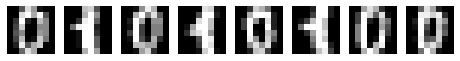

In [2]:
#-------------------------------------------------------- Setting model parameters --------------------------------------------------------#
noise_dim = 5
image_size = 8
model_type = ['Classical_linear', 'Quantum_linear']
labels = [0,1]
num_classes = len(labels)
runs = 2
epochs = 20
batch_size = 4
learning_rate = 0.01
n_samples = 500 # number of samples for inference


#-------------------------------------------------------- Handling real data --------------------------------------------------------#

# Showing real data
digits, targets = datasets.load_digits(return_X_y =True)
digits = digits.reshape(len(digits), 8, 8)

# Selecting only specific labels
real_data, real_img, test_labels = resize_data_one_hot(digits, targets, label=labels, image_size=image_size, num_classes=num_classes)

# Splitting train-test data (one-hot encoding included)
idx = int(len(real_data)*0.8)
train_data, test_data = split_train_test(real_data, idx)
test_label = targets[:idx]

print('Real data sample:')
show_images(real_data, 8)


#-------------------------------------------------------- Making inference --------------------------------------------------------#
len_real_data = len(real_data)

# Bulding synthetic classical dataset (one-hot encoding included)
path = "torch_results/GAN/GAN_linear/"
GAN_imgs, synthetic_classical_data = build_dataset(model_type[0], noise_dim, path, labels, num_classes, n_samples)

# # Bulding synthetic quantum dataset (one-hot encoding included)
q_path = "torch_results/QGAN/QGAN_linear/"
QGAN_imgs, synthetic_quantum_data = build_dataset(model_type[1], noise_dim, q_path, labels, num_classes, n_samples)

# len(synthetic_classical_data), len(synthetic_quantum_data)
# plt.imshow(synthetic_quantum_data[2000][0]), synthetic_quantum_data[2000][1]
# plt.imshow(synthetic_classical_data[2000][0]), synthetic_classical_data[2000][1]

### Accuracy score

In [3]:
#-------------------------------------------------------- Defining dataloaders --------------------------------------------------------#
synthetic_dataloader = DataLoader(synthetic_classical_data, batch_size=batch_size, shuffle=True, drop_last=True)
q_synthetic_dataloader = DataLoader(synthetic_quantum_data, batch_size=batch_size, shuffle=True, drop_last=True)
real_dataloader = DataLoader(real_data, shuffle=True)
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, shuffle=True)


#-------------------------------------------------------- Initializing classificator models --------------------------------------------------------#
r_classificator = Classificator(num_classes)
c_classificator = Classificator(num_classes)
q_classificator = Classificator(num_classes)


#-------------------------------------------------------- Running the classification --------------------------------------------------------#
print('REAL DATA CLASSIFICATION: ')
r_path = "torch_results/Classificator/Real_data/"
r_loss = training_classification(r_classificator, train_dataloader, epochs, learning_rate, batch_size, r_path)
evaluate_accuracy(r_classificator, test_dataloader, r_path)

print('\nSYNTHETIC DATA CLASSIFICATION: ')
acc_tot, q_acc_tot, c_loss, q_loss = multiple_runs(runs, model_type, c_classificator, q_classificator, synthetic_dataloader, q_synthetic_dataloader,
                                                              real_dataloader, num_classes, learning_rate, epochs, batch_size, reset_parameters=True) 

REAL DATA CLASSIFICATION: 


100%|██████████| 20/20 [00:03<00:00,  5.28it/s, Classificator loss=0.323]
2023-02-07 10:08:41.928298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-07 10:08:41.928333: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-07 10:08:41.928347: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vt-bozzololu): /proc/driver/nvidia/version does not exist
2023-02-07 10:08:41.928526: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Accuracy score:  0.9583333333333334

SYNTHETIC DATA CLASSIFICATION: 
---------------------------------------- RUN 1 ----------------------------------------
Classical GAN training: 


100%|██████████| 20/20 [00:11<00:00,  1.69it/s, Classificator loss=0.314]


Accuracy score:  0.9777777777777777
Quantum GAN training: 


100%|██████████| 20/20 [00:14<00:00,  1.42it/s, Classificator loss=0.314]


Accuracy score:  0.9861111111111112
---------------------------------------- RUN 2 ----------------------------------------
Classical GAN training: 


100%|██████████| 20/20 [00:17<00:00,  1.15it/s, Classificator loss=0.314]


Accuracy score:  0.9583333333333334
Quantum GAN training: 


100%|██████████| 20/20 [00:15<00:00,  1.33it/s, Classificator loss=0.314]


Accuracy score:  0.9833333333333333


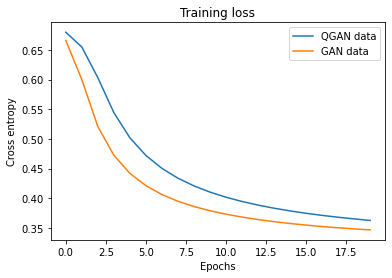

In [4]:
#----------------------- Plotting losses -----------------------#
plt.plot(np.arange(len(c_loss)), q_loss, label='QGAN data')
plt.plot(np.arange(len(c_loss)), c_loss, label='GAN data')
plt.title('Training loss')
plt.ylabel('Cross entropy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

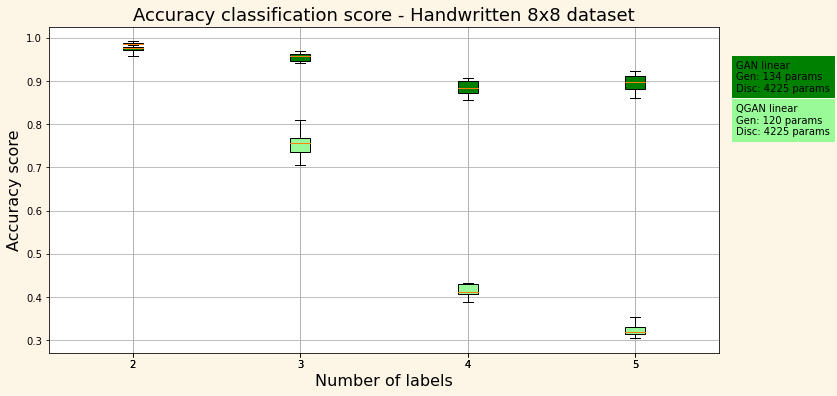

In [5]:
#-------------------------------------------------------- Plotting multiple run results on multiple labels --------------------------------------------------------#

c_acc_2_features = [0.9777777777777777,0.9583333333333334,0.975,0.9777777777777777,0.975,0.9805555555555555,0.9638888888888889,0.9694444444444444,0.9805555555555555,0.9861111111111112]

q_acc_2_features = [0.9861111111111112,0.9833333333333333,0.9944444444444445,0.9888888888888889,0.9888888888888889,0.9861111111111112,0.9916666666666667,0.9861111111111112,0.9833333333333333,
0.9861111111111112]

c_acc_3_features = [0.9590316573556797,0.957169459962756,0.9702048417132216,0.957169459962756,0.9590316573556797,0.9422718808193669,0.9422718808193669,0.9646182495344506,0.962756052141527,
0.9050279329608939]

q_acc_3_features = [0.7579143389199255,0.7541899441340782,0.7318435754189944,0.7318435754189944,0.7430167597765364,0.8100558659217877,0.7635009310986964,0.7057728119180633,0.8081936685288641,
0.7690875232774674]

c_acc_4_features = [0.8680555555555556,0.8694444444444445,0.9013888888888889,0.8819444444444444,0.8777777777777778,0.9027777777777778,0.8986111111111111,0.9069444444444444,0.8861111111111111,
0.8555555555555555]

q_acc_4_features = [0.4708333333333333,0.4986111111111111,0.4083333333333333,0.4166666666666667,0.4097222222222222,0.40555555555555556,0.3888888888888889,0.4125,0.40555555555555556,0.43333333333333335]

c_acc_5_features = [0.9089900110987791,0.9123196448390677,0.9178690344062154,0.8956714761376249,0.8612652608213096,0.8990011098779135,0.8679245283018868,0.876803551609323,0.9223085460599334,
0.897891231964484]

q_acc_5_features = [0.30965593784683687,0.3129855715871254,0.31520532741398444,0.34850166481687017,0.3052164261931188,0.32075471698113206,0.35294117647058826,0.33296337402885684,0.3196448390677026,
0.3174250832408435]

c_acc_final = [c_acc_2_features, c_acc_3_features, c_acc_4_features, c_acc_5_features]
q_acc_final = [q_acc_2_features, q_acc_3_features, q_acc_4_features, q_acc_5_features]

boxplot = accuracy_boxplot(c_acc_final, q_acc_final, [2,3,4,5])
boxplot

/tmp/ipykernel_2449/2216260577.py:17: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([df1, df2, df3], 1)


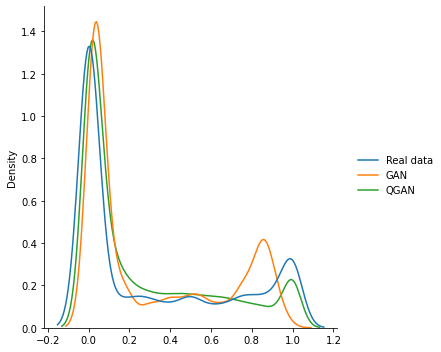

In [6]:
# Plotting kernel density estimation. they're necessary a comparable number iof sample for each group of data (real, GAN, QGAN)

GAN_imgs, _ = build_dataset(model_type[0], noise_dim, path, labels, num_classes, 180)
QGAN_imgs, _ = build_dataset(model_type[1], noise_dim, q_path, labels, num_classes, 180)

linear_gan_synthetic = np.concatenate(GAN_imgs).reshape(len(GAN_imgs), 8, 8)
reshaped_linear_gan_synthetic = linear_gan_synthetic.reshape(len(GAN_imgs)*64)
linear_qgan_synthetic = np.concatenate(QGAN_imgs).reshape(len(QGAN_imgs), 8, 8)
reshaped_linear_qgan_synthetic = linear_qgan_synthetic.reshape(len(QGAN_imgs)*64)
real_data = np.concatenate(real_img).reshape(len(real_img), 8, 8)
reshaped_real_data = real_data.reshape(len(real_data)*64)

empty_dataframe = pd.DataFrame(columns=['Real data','GAN', 'QGAN'])
df1 = pd.DataFrame(reshaped_real_data)
df2 = pd.DataFrame(reshaped_linear_gan_synthetic)
df3 = pd.DataFrame(reshaped_linear_qgan_synthetic)
df = pd.concat([df1, df2, df3], 1)
df.columns = ['Real data','GAN', 'QGAN']

sns.displot(data = df, kind = 'kde')